In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
from glob import glob
import seaborn as sns
# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
base_skin_dir = os.path.join('..', 'input')

# Any results you write to the current directory are saved as output.

['hmnist_28_28_RGB.csv', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'ham10000_images_part_2', 'hmnist_8_8_RGB.csv', 'ham10000_images_part_1', 'hmnist_8_8_L.csv']


In [2]:

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi', #"ben"
    'mel': 'Melanoma', # dermatofibroma -> Melanoma olarak değiştirildi
    'bkl': 'Benign keratosis-like lesions ', #lezyonlar
    'bcc': 'Basal cell carcinoma',#Bazal hücreli karsinom
    'akiec': 'Actinic keratoses', #Aktinik keratozlar
    'vasc': 'Vascular lesions', #Vasküler lezyonlar
    'df': 'Dermatofibroma'
}

In [3]:
print(lesion_type_dict.get("df"))

Dermatofibroma


In [4]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
#display(tile_df)
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
#print(tile_df['path'])
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes #label_encoding
tile_df['is_cancer']=tile_df['dx'].map(lambda x: 1 if x != "nv" else 0)
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,is_cancer
5040,HAM_0007185,ISIC_0025189,nv,follow_up,65.0,male,back,../input/ham10000_images_part_1/ISIC_0025189.jpg,Melanocytic nevi,4,0
7928,HAM_0002874,ISIC_0033912,nv,histo,45.0,male,abdomen,../input/ham10000_images_part_2/ISIC_0033912.jpg,Melanocytic nevi,4,0
9715,HAM_0003989,ISIC_0030714,akiec,histo,70.0,female,face,../input/ham10000_images_part_2/ISIC_0030714.jpg,Actinic keratoses,0,1


In [5]:
tile_df.info()
tile_df.describe(exclude=[np.number])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 11 columns):
lesion_id        10015 non-null object
image_id         10015 non-null object
dx               10015 non-null object
dx_type          10015 non-null object
age              9958 non-null float64
sex              10015 non-null object
localization     10015 non-null object
path             10015 non-null object
cell_type        10015 non-null object
cell_type_idx    10015 non-null int8
is_cancer        10015 non-null int64
dtypes: float64(1), int64(1), int8(1), object(8)
memory usage: 792.3+ KB


,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0000835,ISIC_0030517,nv,histo,male,back,../input/ham10000_images_part_1/ISIC_0026737.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


In [6]:
display(tile_df['cell_type'].value_counts())

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

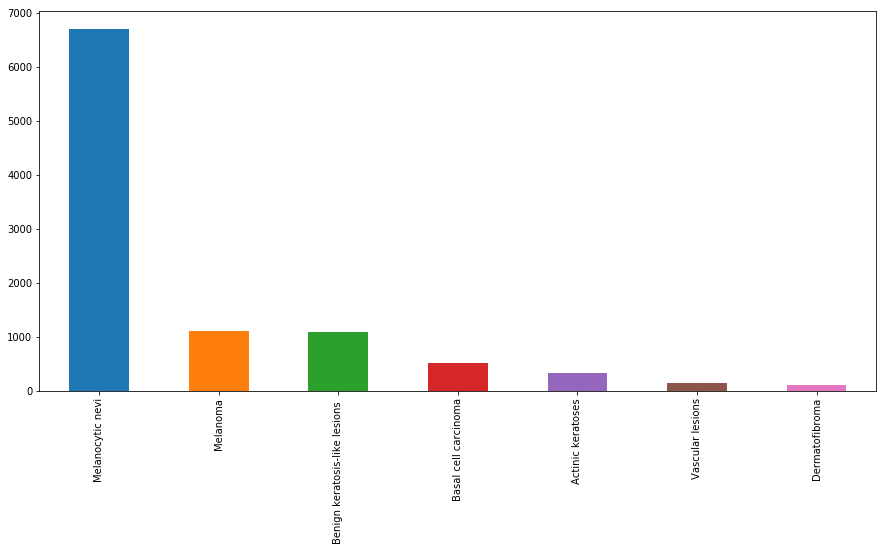

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize= (15, 7))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [8]:
from skimage.io import imread
from tensorflow.image import rgb_to_grayscale
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.resnet50 import preprocess_input
image_size = 100

def read_and_prep_images(img_paths, img_width=image_size, img_height=image_size):
    imgs = [np.asarray(Image.open(img_path).resize((img_height, img_width))) for img_path in img_paths]
    img_arr = [preprocess_input(img) for img in imgs]
    return img_arr

#tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
tile_df['image'] = read_and_prep_images(tile_df['path'], 100, 75)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


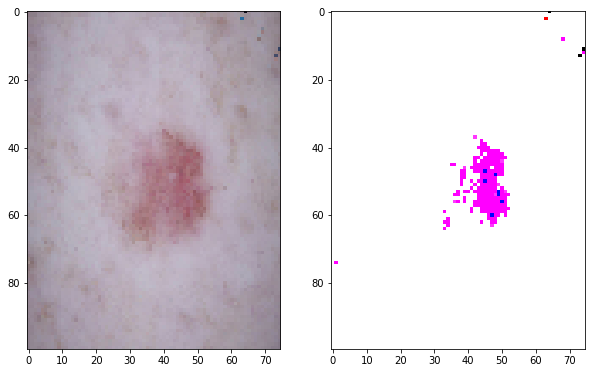

In [9]:

import tensorflow as tf
img = np.asarray(Image.open(tile_df["path"][300]).resize((75, 100)))
img_g = preprocess_input(img)#sekillendiriyo yapılmayabilir
#print(img_g.shape)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img)
ax[1].imshow(img_g, cmap="gray")

In [10]:

tile_df['image'].map(lambda x: x.shape).value_counts()

(100, 75, 3)    10015
Name: image, dtype: int64

In [11]:

"""n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'], cmap='gray')
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)"""

"n_samples = 5\nfig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))\nfor n_axs, (type_name, type_rows) in zip(m_axs, \n                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):\n    n_axs[0].set_title(type_name)\n    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):\n        c_ax.imshow(c_row['image'], cmap='gray')\n        c_ax.axis('off')\nfig.savefig('category_samples.png', dpi=300)"

In [12]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(tile_df['image'], tile_df['is_cancer'], test_size=0.2, random_state=42)
#train_X, validation_X, train_y, validation_y = train_test_split(train_X, train_y, test_size=0.1, random_state=42)

In [13]:
train_X = np.asarray(train_X.tolist())
test_X = np.asarray(test_X.tolist())
#validation_X = np.asarray(validation_X.tolist())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


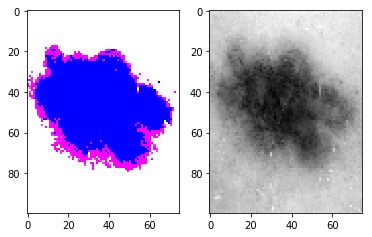

In [14]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

fig, ax = plt.subplots(1,2)
ax[0].imshow(train_X[0])
ax[1].imshow(rgb2gray(train_X[0]), cmap="gray")

In [15]:
x_train_mean = np.mean(train_X)
x_train_std = np.std(train_X)

x_test_mean = np.mean(test_X)
x_test_std = np.std(test_X)

#x_val_mean = np.mean(validation_X)
#x_val_std = np.std(validation_X)

train_X = (train_X - x_train_mean)/x_train_std
test_X = (test_X - x_test_mean)/x_test_std
#validation_X = (validation_X - x_val_mean)/x_val_std

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


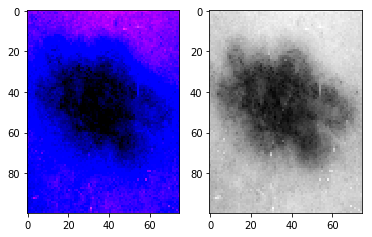

In [16]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(train_X[0])
ax[1].imshow(rgb2gray(train_X[0]), cmap="gray")

In [17]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
train_y = to_categorical(train_y, num_classes = 2)
test_y = to_categorical(test_y, num_classes = 2)
#validation_y = to_categorical(validation_y, num_classes = 2)

Using TensorFlow backend.


In [18]:
import keras as K
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from IPython.display import clear_output

class PlotLosses(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].plot(self.x, self.losses, label="loss")
        ax[0].plot(self.x, self.val_losses, label="val_loss")
        ax[0].legend()
        ax[1].plot(self.x, self.accs, label="accuracy")
        ax[1].plot(self.x, self.val_accs, label="val_accuracy")
        ax[1].legend()
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [19]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve, average_precision_score
import itertools

def plot_confusion_matrix(ax, cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fmt = '.2f'
    tick_marks = np.arange(len(classes))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=90, va="center")
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
def plot_roc_curve(ax, y, y_pred, title="ROC Curve"):
    fpr, tpr, thresholds_roc = roc_curve(y, y_pred)
    roc_auc = auc(fpr,tpr)
    ax.plot(fpr,tpr, label = "AUC = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
    ax.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc = 'best')
    close_default = np.argmin(np.abs(thresholds_roc - 0.5))
    ax.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)

def plot_presicion_recall_curve(ax, y, y_pred_proba, title="Precision-Recall Curve"):
    precision, recall, thresholds_pr = precision_recall_curve(y, y_pred_proba)
    avg_pre = average_precision_score(y, y_pred_proba)
    area = auc(recall, precision)
    ax.plot(recall, precision, label = "Average precision = {:0.2f}, AUC = {:0.2f}".format(avg_pre, area), lw = 3, alpha = 0.7)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc = 'best')
    # plot no skill
    ax.plot([0, 1], [0.5, 0.5], linestyle='--')
    #find default threshold
    close_default = np.argmin(np.abs(thresholds_pr - 0.5))
    ax.plot(precision[close_default], recall[close_default], 'o', markersize = 8)
    
def hastaliklar(model, model_title):
    test_pred = model.predict_classes(test_X)
    test_pred_proba = model.predict_proba(test_X)[:,1]
    
    train_score = model.evaluate(train_X, train_y)[1]
    test_score = model.evaluate(test_X, test_y)[1]
    
    """"classes = list(range(7))
    classes = pd.Categorical.from_codes(classes, sorted(lesion_type_dict.values()))
    classes = np.array(classes)"""
    classes = ["Kansersiz", "Kanserli"]
    sinir = "\n" + "-"*50
    
    print("="*6, "Skorlar", "="*6)
    print("Training Score:\t{:.4f}".format(train_score))
    print("Test Score:\t\t{:.4f}".format(test_score))
    np.set_printoptions(precision=2)
    
    print(sinir)
    print("="*6, "Test Sınıflandırma Raporu", "="*6)
    test_y_uc = pd.DataFrame([np.argmax(y) for y in test_y])
    print(classification_report(test_y_uc, test_pred))
    cnf_matrix1 = confusion_matrix(test_y_uc, test_pred)
    cnf_matrix1_nrm = cnf_matrix1.astype('float') / cnf_matrix1.sum(axis=1)[:, np.newaxis]
    print(sinir)
    
    fig, ax = plt.subplots(1, figsize=(5, 5)) 
    fig.suptitle(model_title, fontsize=20)
    plot_confusion_matrix(ax, cnf_matrix1_nrm, classes, title='Test Confusion Matrix')
    #plot_roc_curve(ax[0,1], test_y_uc, test_pred_proba, title="Test ROC Curve")
    #plot_presicion_recall_curve(ax[0,2], test_y_uc, test_pred_proba, title="Test Precision-Recall Curve")

def precision_hesapla(TP, FP):
    return TP/(TP + FP)

def recall_hesapla(TP, FN):
    return TP/(TP + FN)
    
def ortalama(x):
    return (x[1]+x[2])/2

In [20]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

batch_size = 32

generator = ImageDataGenerator(
    validation_split=0.1,
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False)

generator.fit(train_X)

train_generator = generator.flow(
    train_X,
    train_y,
    batch_size=batch_size,
    subset='training') # set as training data

validation_generator = generator.flow(
    train_X,
    train_y,
    batch_size=batch_size,
    subset='validation') # set as validation data

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [21]:
K.backend.clear_session()
input_shape = (100, 75, 3)
num_classes = 2

model = Sequential()
#model.add(Lambda(lambda x: rgb_to_grayscale(x), input_shape = input_shape))
model.add(Conv2D(128, kernel_size=(3, 3), input_shape = input_shape)
         #,activation="relu"
         )
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(BatchNormalization(momentum=0.3))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.2))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.3))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 73, 128)       3584      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 98, 73, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 71, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 71, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 35, 128)       0         
_________________________________________________________________
batch_normalization_1

In [22]:
model.compile(optimizer=K.optimizers.Adam() , loss = "categorical_crossentropy", metrics=["accuracy"])

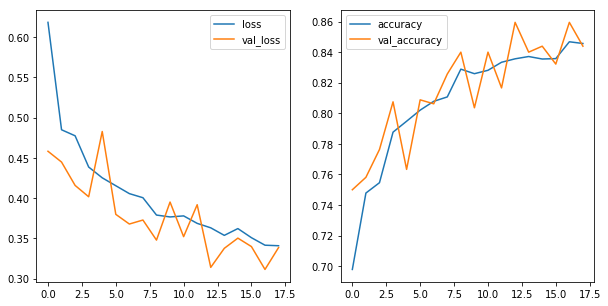

Epoch 19/50
 23/250 [=>............................] - ETA: 11s - loss: 0.3382 - acc: 0.8386

In [23]:
model.fit_generator(generator=train_generator, steps_per_epoch = len(train_X)//batch_size,
                    validation_data=validation_generator, validation_steps = (len(train_X)*0.1)//batch_size,
                    epochs=50, callbacks=[learning_rate_reduction, plot_losses])
""""model.fit_generator(train_generator,epochs=25,
                            steps_per_epoch=80,
                            validation_data=validation_generator,
                            validation_steps = (len(train_X)*0.1)//batch_size,
                            callbacks=[learning_rate_reduction, plot_losses])"""


2003/2003 [==============================] - 1s 413us/step
====== Skorlar ======
Training Score:	0.8732
Test Score:		0.8617

--------------------------------------------------
====== Test Sınıflandırma Raporu ======
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1338
           1       0.80      0.78      0.79       665

   micro avg       0.86      0.86      0.86      2003
   macro avg       0.85      0.84      0.84      2003
weighted avg       0.86      0.86      0.86      2003


--------------------------------------------------


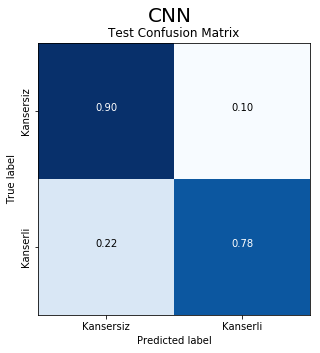

In [24]:
hastaliklar(model, "CNN")

In [25]:
model_json = model.to_json()
with open("./skin_cancer32.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./skin_cancer32.h5")
print("Saved model to disk")

Saved model to disk


In [26]:
"""from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam, RMSprop
epochs = 100

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=(100, 75, 3),
                 pooling='max',
                 classes=7)

model.compile(optimizer = Adam(1e-5) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(train_X, train_y, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()"""

'from keras.applications.resnet50 import ResNet50\nfrom keras.optimizers import Adam, RMSprop\nepochs = 100\n\nmodel = ResNet50(include_top=True,\n                 weights= None,\n                 input_tensor=None,\n                 input_shape=(100, 75, 3),\n                 pooling=\'max\',\n                 classes=7)\n\nmodel.compile(optimizer = Adam(1e-5) ,\n              loss = "binary_crossentropy", \n              metrics=["accuracy"])\n\nhistory = model.fit(train_X, train_y, validation_split=0.2,\n                    epochs= epochs, batch_size= batch_size, verbose=0, \n                    callbacks=[learning_rate_reduction]\n                   )\n\n# list all data in history\nprint(history.history.keys())\n# summarize history for accuracy\nplt.plot(history.history[\'acc\'])\nplt.plot(history.history[\'val_acc\'])\nplt.title(\'model accuracy\')\nplt.ylabel(\'accuracy\')\nplt.xlabel(\'epoch\')\nplt.legend([\'train\', \'test\'], loc=\'upper left\')\nplt.show()\n# summarize histo